In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
sns.set()
import h5py
import matplotlib.lines as mlines

In [3]:
from scipy.stats import pearsonr
from scipy.signal import find_peaks

In [4]:
from Functions import position_gene, NFR_position, heat_map, calculate_nrl

# Loading the data

The experimental data for S.cerevisiae are available with [accession number GSM552910](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM552910).

In [19]:
# We import the experimental landscape of nucleosome on chromosome 16 of S.cerevisiae to find the NFR.
WINDOW = 2001
HALF_WX = WINDOW // 2

proba = pd.read_csv('./Start_data/proba_in_vivo.csv')
y_true = proba[proba.chr == 'chr16'].value.values[HALF_WX : - HALF_WX]

In [27]:
# We import here the prediction on chromosome 16 that we want to study.
y_pred = np.load('../Results_nucleosome/y_pred_CNN_nucleosome_in_vivo.npy')

Renormalisation of the data (this normalization correspond to the one experimentally used by [Tsankov et al.](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1000414) to study the nucleosome occupancy). The normalization using a rolling max is shown to be less efficient to predict the nucleosome occupancy.

In [28]:
y_pred /= np.mean(y_pred)
y_true /= np.mean(y_true)

Applying a moving average for both series

In [32]:
length = 3

y_pred = np.array([np.mean(y_pred[i - length : i + length]) for i in range(length, len(y_pred) - length)])
y_true = np.array([np.mean(y_true[i - length : i + length]) for i in range(length, len(y_true) - length)])

In [33]:
correlation = pearsonr(y_pred[y_true > 0], y_true[y_true > 0])[0]
print 'Correlation between true and pred :', correlation

Correlation between true and pred : 0.37076485948467264


<IPython.core.display.Javascript object>


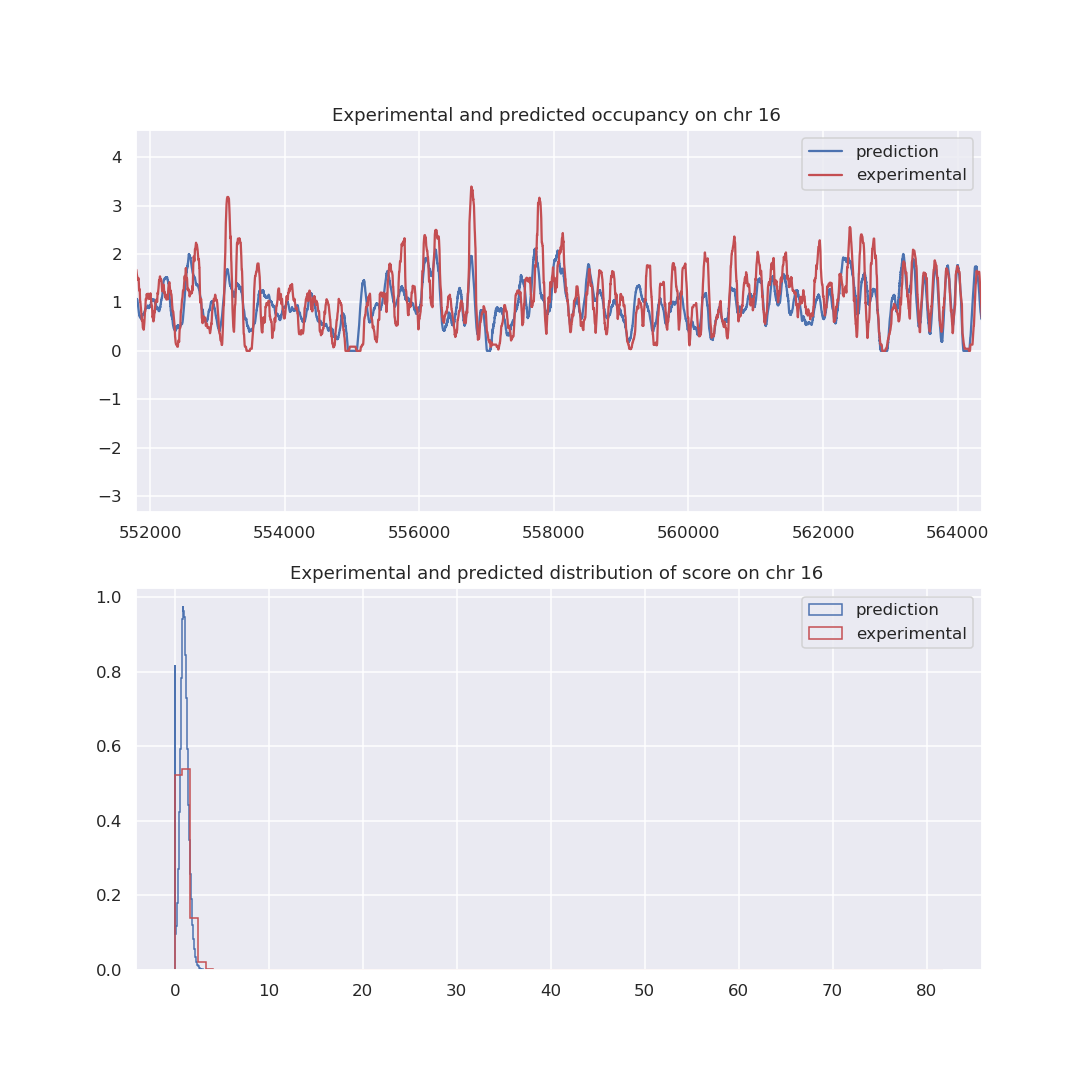

In [34]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,1,1)
ax.plot(y_pred, 'b', label='prediction')
ax.plot(y_true, 'r', label='experimental')
ax.legend()
ax2 = fig.add_subplot(2,1,2)
ax2.hist(y_pred, bins=100, density=True,
         histtype='step', color='b', label='prediction')
ax2.hist(y_true, bins=100, density=True,
         histtype='step', color='r', label='experimental')
ax2.legend()
ax.set_title('Experimental and predicted occupancy on chr 16 ')
ax2.set_title('Experimental and predicted distribution of score on chr 16 ')

plt.show()

#  Mean nucleosome occupancy in TSS region

The nucleosome occupancy displays a characteristic pattern in TSS region that we want our model to be able to predict. This pattern is a relatively low nucleosome occupancy before the TSS followed by a regular positioning of nucleosome with the periodicity 167 in S.cerevisiae.

In [8]:
gene_positions = pd.read_table('./Start_data/position_genes.txt', sep = '\t')
gene_positions.head()

,Chr,Replicon Accession,Start,Stop,Strand,GeneID,Locus,Locus tag,Protein product,Length,Protein name
0,XVI,NC_001148.4,280,6007,-,855846,YRF1-7,YPL283C,NP_015040.1,1859,Y\' element ATP-dependent helicase protein 1 c...
1,XVI,NC_001148.4,7933,8427,-,855847,PAU22,YPL282C,NP_015041.1,164,seripauperin PAU22
2,XVI,NC_001148.4,9557,10870,-,855848,ERR2,YPL281C,NP_015042.1,437,phosphopyruvate hydratase ERR2
3,XVI,NC_001148.4,11887,12600,+,855849,HSP32,YPL280W,NP_015043.1,237,glutathione-independent methylglyoxalase famil...
4,XVI,NC_001148.4,13228,14355,-,855850,FEX2,YPL279C,NP_015044.1,375,fluoride transporter


In [21]:
tss_occupancy_pred = heat_map(y_pred, y_true, gene_positions, HALF_WX, 'tss')
tss_occupancy_true = heat_map(y_true, y_true, gene_positions, HALF_WX, 'tss')

We look at the heat map of nucleosome occupancy in the TSS region (both predicted and experimental). The mean occupancy in this region displays the characteristic regular pattern.

Experimental NRL : 159.0
Predicted NRL : 162.2


<IPython.core.display.Javascript object>


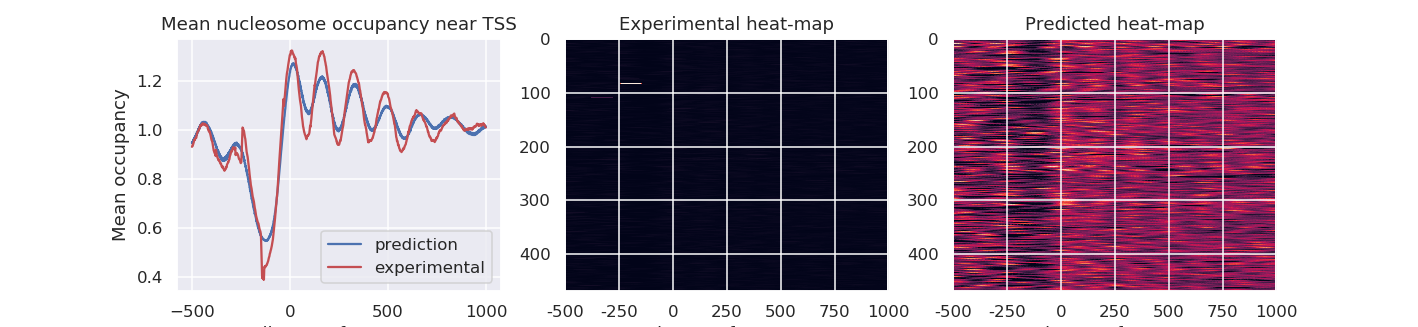

[Text(0,0,'-500'),
 Text(0,0,'-250'),
 Text(0,0,'0'),
 Text(0,0,'250'),
 Text(0,0,'500'),
 Text(0,0,'750'),
 Text(0,0,'1000')]

In [31]:
print 'Experimental NRL : {}'.format(calculate_nrl(tss_occupancy_true))
print 'Predicted NRL : {}'.format(calculate_nrl(tss_occupancy_pred))

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(13,3),dpi=100,num=1)

ax1.plot(range(-500, 1000),
         np.mean(tss_occupancy_pred, axis=0),
         color='b',
         label='prediction')
ax1.plot(range(-500, 1000),
         np.mean(tss_occupancy_true, axis=0),
         color='r',
         label='experimental')
ax1.set(title='Mean nucleosome occupancy near TSS',
        xlabel='distance from TSS',
        ylabel='Mean occupancy')
ax1.legend()

ax2.imshow(tss_occupancy_true, aspect='auto')
ax2.set(title='Experimental heat-map',
        xlabel='Distance from TSS')
ax2.set_xticks(np.arange(0, 1501, 250))
ax2.set_xticklabels(np.arange(-500, 1001, 250))

ax3.imshow(tss_occupancy_pred, aspect='auto')
ax3.set(title='Predicted heat-map',
        xlabel='Distance from TSS')
ax3.set_xticks(np.arange(0, 1501, 250))
ax3.set_xticklabels(np.arange(-500, 1001, 250))

The NFR are the determinant part of the prediction.

The precision of their prediction can be assess by representing the predicted distances between the TSS and the NFR in function of their experimental counterparts. 

Then we can plot the ratio of NFR that are predicted whitin a distance from the experimental NFR.

In [ ]:
nfr_pos_true = NFR_position(y_true, HALF_WX, gene_positions)
nfr_pos_pred = NFR_position(y_pred, HALF_WX, gene_positions)
gene_pos = position_gene(gene_positions, HALF_WX, y_true)

dist_TSS_NFR_true = np.append(np.abs(nfr_pos_true[nfr_pos_true.strand == '+'].nfr_pos.values - gene_pos[2]),
                              np.abs(nfr_pos_true[nfr_pos_true.strand == '-'].nfr_pos.values - gene_pos[3]))

dist_TSS_NFR_pred = np.append(np.abs(nfr_pos_pred[nfr_pos_pred.strand == '+'].nfr_pos.values - gene_pos[2]),
                              np.abs(nfr_pos_pred[nfr_pos_pred.strand == '-'].nfr_pos.values - gene_pos[3]))

diff = np.abs(nfr_pos_true.nfr_pos.values - nfr_pos_pred.nfr_pos.values)
ratios = np.array([len(diff[diff < i]) / float(len(diff)) for i in range(1000)])

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10,5))

ax.plot(dist_TSS_NFR_true, dist_TSS_NFR_pred,
        linestyle='', marker='o', markersize=1.0, color ='royalblue')
ax.plot(range(100,800), range(0,700), linestyle='--', linewidth = 0.8, color = 'r')
ax.plot(range(0,800), range(100,900), linestyle='--', linewidth = 0.8, color = 'r')

ax.set(xlabel='Experimental distance from TSS to NFR',
       ylabel='Predicted distance from TSS to NFR',
       title='Scatter plot of NFR-TSS distances')

ax1.plot(ratios, color='royalblue',
         label='AUC : {}'.format(round(np.sum(ratios)) / 1000.))
ax1.set(title='Ratio of predicted NFR',
        ylabel='ratio of predicted NFR within the distance',
        xlabel='distance from real NFR')
ax1.legend()

## Evaluating the quality of the prediction in function of the gene activity

It is likely that the quality of prediction on a gene is anti-correlated with the gene activity. In fact the RNA-polymerase can change the organisation of the nucleosome during transcription adding noise to their structure. It is likely that this noise is dependant on the activity of the gene.

In [ ]:
rna_seq = pd.read_csv('./Start_data/rna_seq_SRR7131299.csv')
rna_seq = rna_seq[rna_seq.chr == 'chr16'].value.values
rna_seq = np.abs(rna_seq)

gene_pos_start, gene_pos_stop, _, _ = position_gene(gene_positions, HALF_WX, y_true)
gene_pos = zip(gene_pos_start, gene_pos_stop)

In [ ]:
genes_activity = np.array([np.mean(rna_seq[start : stop], axis=0) for start, stop in gene_pos])
genes_prediction_qual = np.array([pearsonr(y_true[start : stop],
                                           y_pred[start : stop])[0] for start, stop in gene_pos])

genes_activity = genes_activity[~np.isnan(genes_prediction_qual)]
genes_prediction_qual = genes_prediction_qual[~np.isnan(genes_prediction_qual)]

fig, ax = plt.subplots(1, 1, figsize=(6,5))

ax.plot(genes_activity,
        genes_prediction_qual,
        label='correlation : {}'.format(pearsonr(genes_activity, genes_prediction_qual)[0]),
        color='royalblue',
        marker='o',
        linestyle='',
        markersize=0.9)
ax.set(title='Prediction quality vs genes activity',
       xlabel='mean gene activity',
       ylabel='correlation between pred and true on the gene')
ax.legend()

## Evaluating the prediction in several other species

We predict on several different species the nucleosome occupancy with the model trained on S.cerevisiae.
We want to observe if the model is able to adapt to a new genome, and especially to look at its periodicity adaptation.

To be more precise the evaluation is made on :
    - K.lactis, chr 6
    - D.hansenii, chr 3
    - C.albicans, chr 1
    - Y.lipolytica, chr 1
The experimental landscape in vivo were taken from the study of [Tsankov et al.](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1000414) and are available with [accession number GSE21960](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE21960)

In [ ]:
# We import the experimental landscape of nucleosome on several species.
WINDOW = 2001
HALF_WX = WINDOW // 2

proba_klac = pd.read_csv('./Start_data/proba_klac.csv')
y_klac = proba[proba.chr == 'chr6'].value.values[HALF_WX : - HALF_WX]

proba_dhan = pd.read_csv('./Start_data/proba_dhan.csv')
y_dhan = proba[proba.chr == 'chr3'].value.values[HALF_WX : - HALF_WX]

proba_calb = pd.read_csv('./Start_data/proba_calb.csv')
y_calb = proba[proba.chr == 'chr1'].value.values[HALF_WX : - HALF_WX]

proba_ylip = pd.read_csv('./Start_data/proba_ylip.csv')
y_ylip = proba[proba.chr == 'chr1'].value.values[HALF_WX : - HALF_WX]

In [ ]:
y_pred_klac = np.load('../Results_nucleosome/y_pred_klac.npy')
y_pred_dhan = np.load('../Results_nucleosome/y_pred_dhan.npy')
y_pred_calb = np.load('../Results_nucleosome/y_pred_calb.npy')
y_pred_ylip = np.load('../Results_nucleosome/y_pred_ylip.npy')

In [ ]:
gene_klac = pd.read_csv('./Start_data/Tsankov_dataset/position_genes_Klac.chrF.csv')
gene_klac = gene_klac[gene_klac.type == 'gene']

gene_dhan = pd.read_csv('./Start_data/Tsankov_dataset/position_genes_Dhan.chrC.csv')
gene_dhan = gene_dhan[gene_dhan.type == 'gene']

gene_calb = pd.read_csv('./Start_data/Tsankov_dataset/position_genes_Calb.chrA.csv')
gene_calb = gene_calb[gene_calb.type == 'gene']

gene_ylip = pd.read_csv('./Start_data/Tsankov_dataset/position_genes_Ylip.chrA.csv')
gene_ylip = gene_ylip[gene_ylip.type == 'gene']

In [ ]:
tss_occupancy_pred_klac = heat_map(y_pred_klac, y_klac, gene_klac, HALF_WX, 'nuc_true')
tss_occupancy_klac = heat_map(y_klac, y_klac, gene_klac, HALF_WX, 'nuc_true')

tss_occupancy_pred_dhan = heat_map(y_pred_dhan, y_dhan, gene_dhan, HALF_WX, 'nuc_true')
tss_occupancy_dhan = heat_map(y_dhan, y_dhan, gene_dhan, HALF_WX, 'nuc_true')

tss_occupancy_pred_calb = heat_map(y_pred_calb, y_calb, gene_calb, HALF_WX, 'nuc_true')
tss_occupancy_calb = heat_map(y_calb, y_calb, gene_calb, HALF_WX, 'nuc_true')

tss_occupancy_pred_ylip = heat_map(y_pred_ylip, y_ylip, gene_ylip, HALF_WX, 'nuc_true')
tss_occupancy_ylip = heat_map(y_ylip, y_ylip, gene_ylip, HALF_WX, 'nuc_true')

#### Evaluating the Nucleosome Repeat Length

In [ ]:
nrl_klac = calculate_nrl(tss_occupancy_klac)
nrl_pred_klac = calculate_nrl(tss_occupancy_pred_klac)

nrl_dhan = calculate_nrl(tss_occupancy_dhan)
nrl_pred_dhan = calculate_nrl(tss_occupancy_pred_dhan)

nrl_calb = calculate_nrl(tss_occupancy_calb)
nrl_pred_calb = calculate_nrl(tss_occupancy_pred_calb)

nrl_ylip = calculate_nrl(tss_occupancy_ylip)
nrl_pred_ylip = calculate_nrl(tss_occupancy_pred_ylip)

In [23]:
N = 4
nrl_true = (nrl_klac, nrl_dhan, nrl_calb, nrl_ylip)
nrl_pred = (nrl_pred_klac, nrl_pred_dhan, nrl_pred_calb, nrl_pred_ylip)

ind = np.arange(N) 
width = 0.35       

fig, ax = plt.subplots(1, 1)
ax.bar(ind, nrl_true, width, label='Experimental NRL', color='red')
ax.bar(ind + width, nrl_pred, width, label='Predicted NRL', color='blue')

ax.set(ylabel='Nucleosome Repeat Length',
       title='Experimental and predicted NRL for the four species')
ax.set_ylim(150, 179)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(['Klac', 'Dhan', 'Calb', 'Ylip'])
ax.legend(loc='best')

plt.show()

NameError: name 'nrl_klac' is not defined

#### Plotting the mean occupancy in TSS region

We align the mean occupancy to the experimental N+1 so that to replicate the alignment in [Tsankov et al.](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1000414).

In [ ]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(2,2,figsize=(8,8),dpi=100,num=1)

ax1.plot(range(-500, 1000),
         np.mean(tss_occupancy_pred_klac, axis=0),
         color='b',
         label='prediction')
ax1.plot(range(-500, 1000),
         np.mean(tss_occupancy_klac, axis=0),
         color='r',
         label='experimental')
ax1.set(title='Mean nucleosome occupancy near TSS for Klac',
        xlabel='distance from TSS',
        ylabel='Mean occupancy')
ax1.legend()

ax2.plot(range(-500, 1000),
         np.mean(tss_occupancy_pred_dhan, axis=0),
         color='b',
         label='prediction')
ax2.plot(range(-500, 1000),
         np.mean(tss_occupancy_dhan, axis=0),
         color='r',
         label='experimental')
ax2.set(title='Mean nucleosome occupancy near TSS for Dhan',
        xlabel='distance from TSS',
        ylabel='Mean occupancy')
ax2.legend()

ax3.plot(range(-500, 1000),
         np.mean(tss_occupancy_pred_calb, axis=0),
         color='b',
         label='prediction')
ax3.plot(range(-500, 1000),
         np.mean(tss_occupancy_calb, axis=0),
         color='r',
         label='experimental')
ax3.set(title='Mean nucleosome occupancy near TSS for Calb',
        xlabel='distance from TSS',
        ylabel='Mean occupancy')
ax3.legend()

ax4.plot(range(-500, 1000),
         np.mean(tss_occupancy_pred_ylip, axis=0),
         color='b',
         label='prediction')
ax4.plot(range(-500, 1000),
         np.mean(tss_occupancy_ylip, axis=0),
         color='r',
         label='experimental')
ax4.set(title='Mean nucleosome occupancy near TSS for Ylip',
        xlabel='distance from TSS',
        ylabel='Mean occupancy')
ax4.legend()